In [1]:
import pickle as pkl
from astropy.cosmology import Planck18
import numpy as np
from scipy.special import erfc
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
with open('train_preprocessed.pkl', 'rb') as f:
    data = pkl.load(f)

In [3]:
def fluxToMag(f):
    m  = -2.5 * np.log10(f)
    return m

def magToFlux(m):
    f = 10**(-0.4*m)
    return f

def fluxToMagErr(f, df):
    dm = np.abs(2.5 / np.log(10) * df / f)

    return dm

def magToFluxErr(m, dm):
    df = np.abs(dm * 10**(-0.4*m) * np.log(10)/-2.5)
    return df

mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def correctMag(m, z):
    dmod = distmodWithCache(z)
    return m - dmod

def correctMagErr(merr, z, zerr):
    d_upper = distmodWithCache(z+zerr)
    d_lower = distmodWithCache(z-zerr)

    d_err = np.abs(d_upper - d_lower)/2
    return np.sqrt(merr**2+d_err**2)

In [4]:
def weightedMean(data, weights, dates, obs_date, tolerance, flux = True):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

In [5]:
mags = []
magerr = []
z = []

for obs in tqdm(data):
    if(len(obs["g"]) > 0):
        mag, error = weightedMean(obs["g"]["mag"], obs["g"]["magerr"], obs["g"]["hmjd"], obs["desi_date"], float("inf"))
        z.append(obs["z"])
        mags.append(mag)
        magerr.append(error)

100%|██████████| 1292763/1292763 [07:16<00:00, 2958.44it/s] 


In [6]:
mag_cache = {}
def distmodWithCache(z):
    if z not in mag_cache:
        dmod = Planck18.distmod(z).value
        mag_cache[z] = dmod
    return mag_cache[z]

def make_likelihood_func(mags, magerr, z, mag_lim):
    margerr = np.asarray(magerr)
    magerr_square = np.square(magerr)
    mags = np.asarray(mags)
    distmod = np.asarray([distmodWithCache(i) for i in z])
    
    mlim_diff = np.subtract(mag_lim, mags)
    def get_ll(params):
        int_disp = params[0]
        true_mag =params[1]
        
        tot_err = np.sqrt(np.add(magerr_square, int_disp**2))
        sq_devs = np.square(np.subtract(mags, np.add(distmod, true_mag)))
        #calculate the final terms
        term1 = np.sum(np.log(np.multiply(2*np.pi, tot_err)))*(1/2)
        
        term2 = (1/2)*np.sum(np.divide(sq_devs, tot_err))
        
        term3 = (1/2) * np.divide(mlim_diff, np.sqrt(np.multiply(tot_err, 2)))
        term3 = 1* np.sum(np.log(np.multiply(0.5, erfc(term3))))

        
        return term1+term2+term3
    
    return get_ll
        

In [7]:
ll_func = make_likelihood_func(mags, magerr, z, 22.5)

In [8]:
out = scipy.optimize.minimize(ll_func, x0 = (4, 20), method = 'Nelder-Mead')
print(out)

 final_simplex: (array([[  0.8371816 , -24.39450908],
       [  0.83717398, -24.3945292 ],
       [  0.83716399, -24.3945067 ]]), array([222609.36380091, 222609.3638436 , 222609.3638743 ]))
           fun: 222609.36380090564
       message: 'Optimization terminated successfully.'
          nfev: 299
           nit: 151
        status: 0
       success: True
             x: array([  0.8371816 , -24.39450908])


In [9]:
tid_g=np.load('/global/u1/z/zhaozhon/k-correction/tid_g.npy')
k_g=np.load('/global/u1/z/zhaozhon/k-correction/k_g.npy')
index_g=np.load('/global/u1/z/zhaozhon/k-correction/index_g.npy')
abs_mag_g=np.load('/global/u1/z/zhaozhon/task/abs_mag_g.npy')
magerr_g_1=np.load('/global/u1/z/zhaozhon/task/magerr_g_1.npy')
z_g = np.load('/global/u1/z/zhaozhon/task/z_g.npy')
filtered_abs_mag_g = abs_mag_g[index_g]
filtered_magerr_g_1 = magerr_g_1[index_g]
filtered_z_g = z_g[index_g]
k_abs_mag_g = filtered_abs_mag_g - k_g

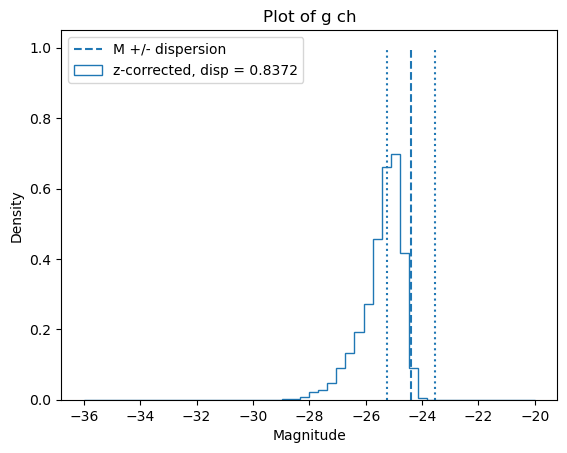

In [10]:
uncorr_d = round(out.x[0], 4)
plt.vlines(out.x[1], 0, 1, linestyles='dashed', label = "M +/- dispersion")
plt.vlines([out.x[1]- out.x[0], out.x[1]+ out.x[0]], 0, 1, linestyles='dotted')
plt.hist(filtered_abs_mag_g, density = True, range = [-36, -20], histtype = "step", bins=50, label = f"z-corrected, disp = {str(uncorr_d)}")
plt.title("Plot of g ch")
plt.ylabel("Density")
plt.xlabel("Magnitude")
plt.legend(loc = "upper left")
plt.show()